# Concentration de CO$_2$ dans l'atmosphère 

In [1]:
%matplotlib inline
import numpy as np
import numpy.fft as fft
from matplotlib import pyplot as plt
import os
import urllib.request
import datetime

### Importation des donnees

Telechargement / gestion de la copie locale

In [2]:
data_url = 'http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'
data_file = 'weekly_in_situ_co2_mlo.csv'
timestamp_file = 'data_download_time'
if os.path.exists(data_file):
    timestamp = open(timestamp_file).read()
    print("Data download time: ", timestamp)
else:
    urllib.request.urlretrieve(data_url, data_file)
    with open(timestamp_file, 'w') as file:
        file.write(str(datetime.datetime.now()))

Data download time:  2018-06-21 11:01:01.820158


Lecture des donnees

In [3]:
import csv
reader = csv.reader(open(data_file))
for i in range(44):
    reader.__next__()
dates = []
concentrations = []
for date_str, concentration_str in reader:
    dates.append(datetime.datetime.strptime(date_str, "%Y-%m-%d").date())
    concentrations.append(float(concentration_str))

Conversion en tableaux NumPy - c'est plus facile a gerer par la suite

In [4]:
dates = np.array(dates)
concentrations = np.array(concentrations)

Pour travailler avec une suite chronologique, un axe de temps est bien plus pratique que des etiquettes de dates. Nous utilisons les jours depuis la premiere observation comme variable de temps.

In [5]:
time = np.array([d.days for d in dates-dates[0]])

## Inspection visuelle

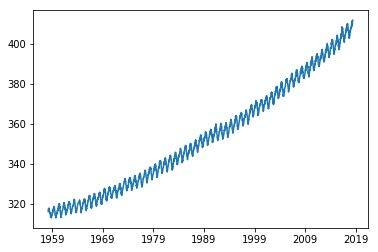

In [6]:
plt.plot(dates, concentrations)

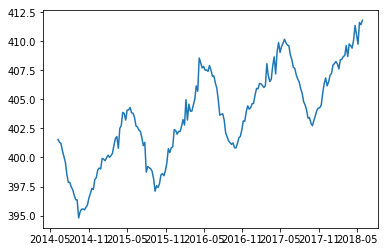

In [7]:
plt.plot(dates[-4*52:], concentrations[-4*52:])

### Donnees manquantes

In [8]:
diffs = time[1:]-time[:-1]
assert min(diffs) == 7
print(max(diffs))

133


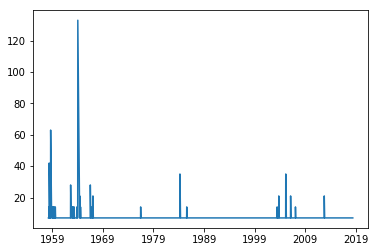

In [9]:
plt.plot(dates[:-1], diffs)

Il y a des gros trous qu'on ne peut pas simplement ignorer!

### Analyse des oscillations rapides

Principe: analyse de Fourier. Pour simplifier, nous travaillons sur une sous-suite chronologique sans points manquants.

In [10]:
subset_indices = np.index_exp[1400:2200]
assert max(diffs[subset_indices]) == 7
subset = concentrations[subset_indices]

Il faut appliquer la FFT a une version nettoyee des donnees dont la composante lineaire a ete supprimee, parce que la FFT sous-entend des donneees periodiques.

In [11]:
t = np.arange(len(subset))
linear_fit = np.polyfit(t, subset, 1)
ft = fft.fft(subset-linear_fit[0]*t-linear_fit[1])

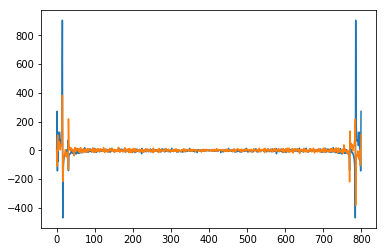

In [12]:
plt.plot(ft.real)
plt.plot(ft.imag)

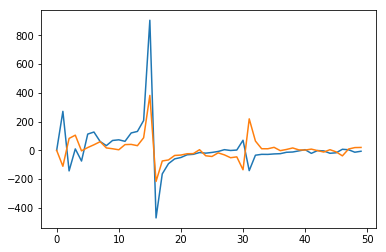

In [13]:
plt.plot(ft.real[:50])
plt.plot(ft.imag[:50])

Le pic principal correspond a ...

In [14]:
len(subset) / 15.

53.333333333333336

... une annee. Tentons a isoler tout ce qui est > `len(subset)/10` (environ 80 semaines).

In [15]:
cutoff = 10
middle = int(len(subset)/2)

fast_ft = 0.*ft
fast_ft[cutoff:middle] = ft[cutoff:middle]
fast_ft[-middle:-cutoff] = ft[-middle:-cutoff]
oscillations = fft.ifft(fast_ft).real

In [16]:
slow = subset-oscillations

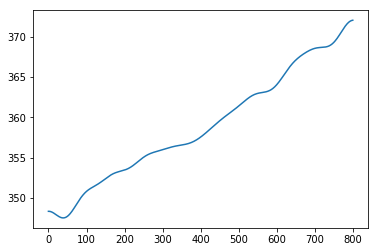

In [17]:
plt.plot(slow)

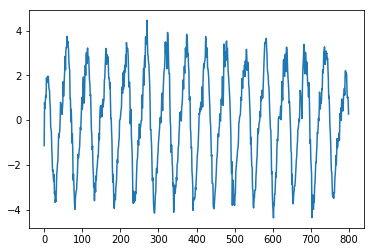

In [18]:
plt.plot(oscillations)

### Analyse des evolutions lentes

Il est preferable de travailler avec une suite chronologique definie sur une grille de temps reguliere. Nous le faisons en remplacant les points manquants par une interpolation lineaire de leurs voisins. Etant donne que nous allons lisser sur des periodes de > 80 semaines, compare avec une distance maximale de 19 semaines entre deux observations, ceci ne devrait pas avoir d'impact sur l'analyse des changements lents.

In [19]:
time_grid = np.arange(0, time[-1], 7)
date_grid = [dates[0] + datetime.timedelta(int(d)) for d in time_grid]
interpolation = np.interp(time_grid, time, concentrations)

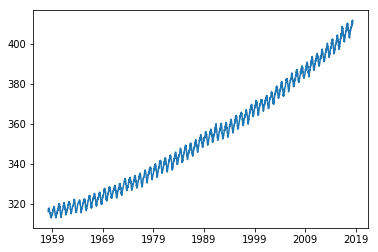

In [20]:
plt.plot(date_grid, interpolation)

Nous repetons l'analyse de Fourier avec le jeux de donnees complet. Attention, il y a plus de points, donc l'echelle des frequences n'est plus la meme !

In [21]:
linear_fit = np.polyfit(time_grid, interpolation, 1)
ft = fft.fft(interpolation-linear_fit[0]*time_grid-linear_fit[1])

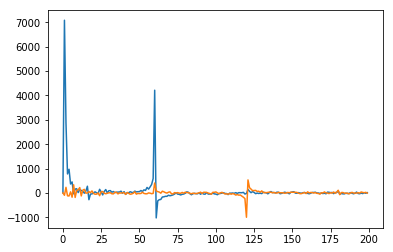

In [22]:
plt.plot(ft.real[:200])
plt.plot(ft.imag[:200])

In [23]:
cutoff = 40
middle = int(len(time_grid)/2)

fast_ft = 0.*ft
fast_ft[cutoff:middle] = ft[cutoff:middle]
fast_ft[-middle:-cutoff] = ft[-middle:-cutoff]
oscillations = fft.ifft(fast_ft).real
slow = interpolation-oscillations

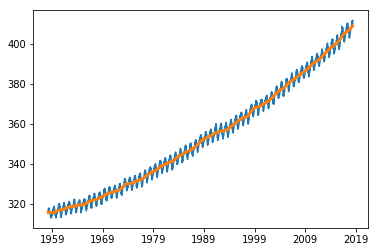

In [24]:
plt.plot(date_grid, interpolation)
plt.plot(date_grid, slow, linewidth=3)

Il nous reste a decrire l'evolution lente avec un modele. Tentons avec un polynome d'ordre 2.

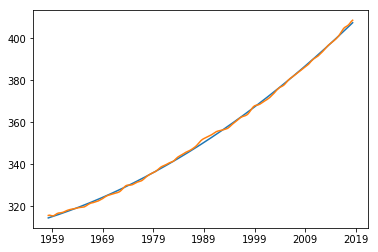

In [25]:
a2, a1, a0 = np.polyfit(time_grid, slow, 2)
plt.plot(date_grid, time_grid*(time_grid*a2 + a1) + a0)
plt.plot(date_grid, slow)

### Extrapolation

In [26]:
endpoint = (datetime.date(2025, 8, 1)-dates[0]).days
extended_time_grid = np.arange(0, endpoint, 7)
extended_date_grid = [dates[0] + datetime.timedelta(int(d)) for d in extended_time_grid]

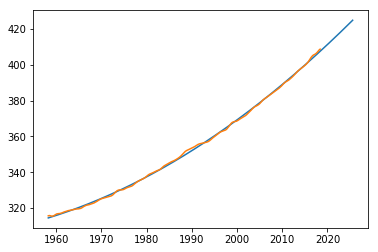

In [27]:
plt.plot(extended_date_grid, extended_time_grid*(extended_time_grid*a2 + a1) + a0)
plt.plot(date_grid, slow)